# OPAL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 2 Jun 2023

### Import OPAL framework and required classes

In [1]:
import sys
sys.path.append('../')
from opal import *
import numpy as np

### Define the linac elements

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -5e-9 # [C]
driver.energy = 10e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 20e-6 # [m]
driver.z_offset = 120e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 5000

# define stage
stage = StageNonlinear1d()
stage.length = 1 # [m]
stage.plasma_density = 2e22 # [m^-3]
stage.nom_energy_gain = 5.5e9 # [eV]
stage.driver_source = driver
stage.ramp_beta_mag = 10

# define beam
source = SourceBasic()
source.charge = -2.7e-9 # [C]
source.energy = 3e9 # [eV]
source.rel_energy_spread = 0.005
source.bunch_length = 12e-6 # [m]
source.z_offset = -60e-6 # [m]
source.emit_nx = 10e-6 # [m rad]
source.emit_ny = 0.035e-6 # [m rad]
source.beta_x = stage.get_matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 1000

# define interstage (of energy-dependent length)
interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.get_matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 0.5 # [T]

# define linac
linac = Linac(source, stage, interstage, num_stages=5)

### Perform linac tracking

In [3]:
# perform tracking run (3 shots)
linac.run("linac_example", shots=1, overwrite=True);

Tracking element #1 (s = 0.0 m, -2.70 nC, 3.0 GeV, SourceBasic, stage 0)
Tracking element #2 (s = 1.0 m, -2.70 nC, 8.7 GeV, StageNonlinear1d, stage 1)
Tracking element #3 (s = 5.4 m, -2.70 nC, 8.7 GeV, InterstageBasic, stage 1)
Tracking element #4 (s = 6.4 m, -2.70 nC, 14.1 GeV, StageNonlinear1d, stage 2)
Tracking element #5 (s = 12.1 m, -2.70 nC, 14.1 GeV, InterstageBasic, stage 2)
Tracking element #6 (s = 13.1 m, -2.70 nC, 19.4 GeV, StageNonlinear1d, stage 3)
Tracking element #7 (s = 19.8 m, -2.70 nC, 19.4 GeV, InterstageBasic, stage 3)
Tracking element #8 (s = 20.8 m, -2.70 nC, 24.8 GeV, StageNonlinear1d, stage 4)
Tracking element #9 (s = 28.3 m, -2.70 nC, 24.8 GeV, InterstageBasic, stage 4)
Tracking element #10 (s = 29.3 m, -2.70 nC, 30.3 GeV, StageNonlinear1d, stage 5)


### Plot the wakefield

(0.30789730927996184, 0.7288947834884477, 0.4224166728240026)

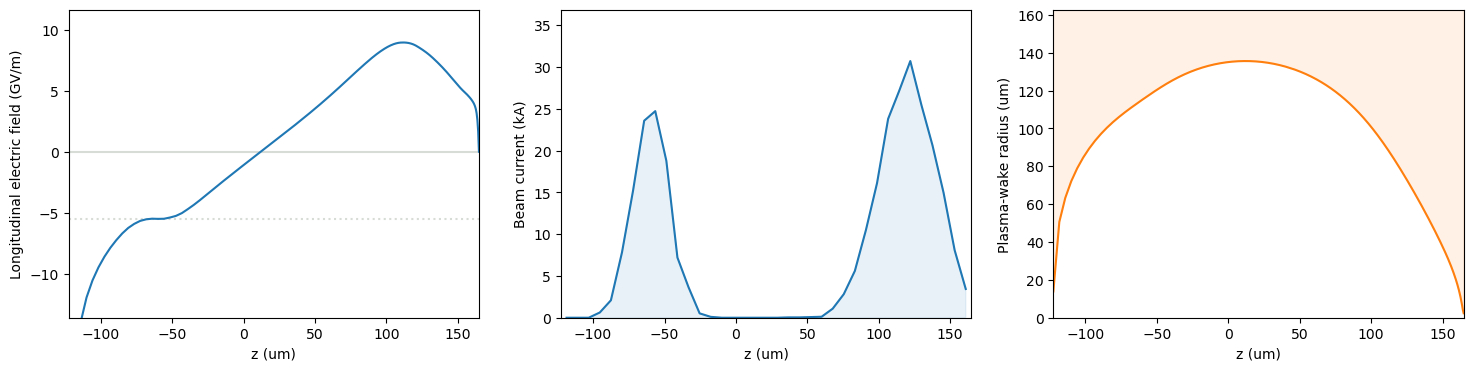

In [4]:
# plot wakefield
stage.plot_wakefield(linac.initial_beam())
linac.stages[0].get_energy_efficiency()

### Plot beam evolution and survey

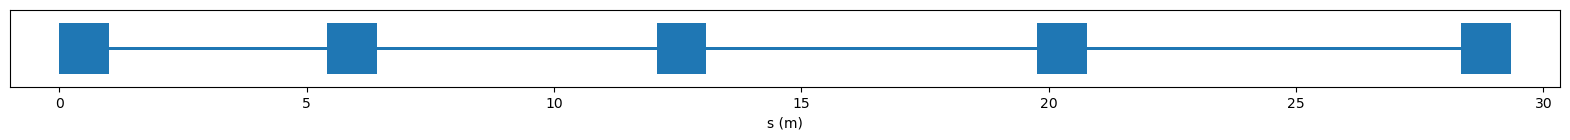

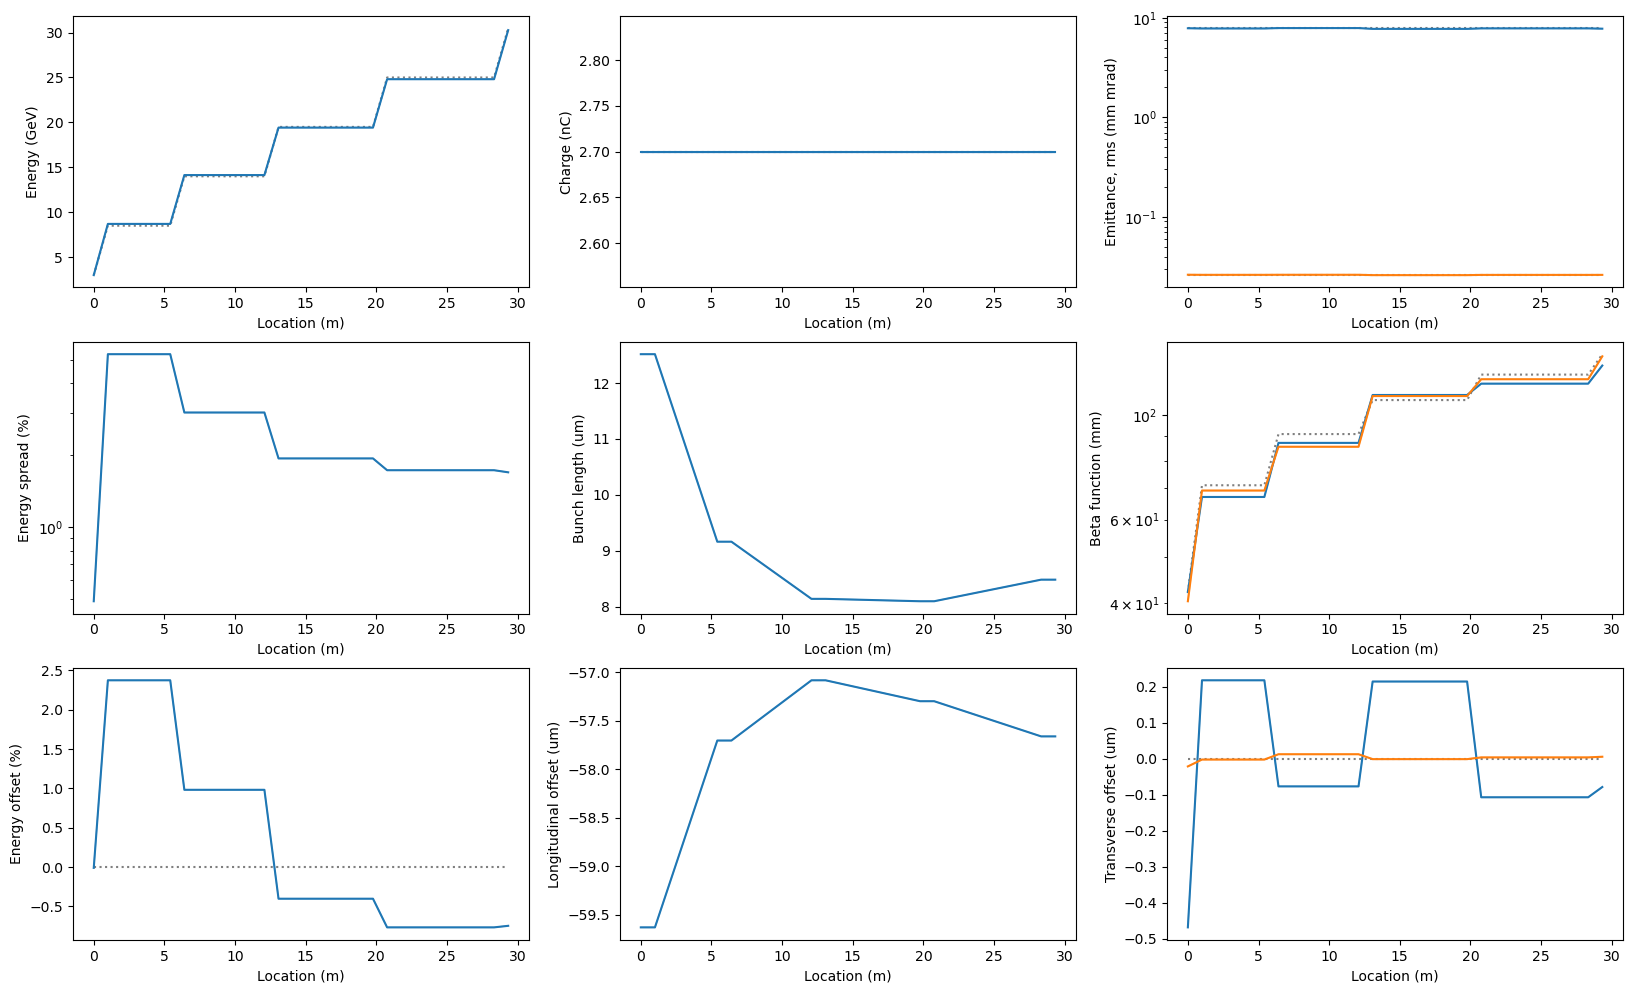

In [5]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution()